## Addressing Issues in the Previous MLP-based Approach

### **Problem – 1: Abnormally High Initial Loss** (implemented in '3_MLP_v2.ipynb')

During the initial phase of training, the model exhibited a cross-entropy loss of approximately **27.051**, which is significantly higher than expected. In the worst-case scenario, if the model were to output a **uniform probability distribution** over the vocabulary (size = 27), each token would have probability:

$$
p = \frac{1}{27}
$$

The corresponding cross-entropy loss in such a case would be:

$$
\mathcal{L} = -\log\left(\frac{1}{27}\right) \approx 3.2958
$$

Thus, the observed loss is disproportionately larger than this theoretical baseline, strongly suggesting **poor initialization of the output layer parameters**, which results in highly skewed probability distributions at the onset of training.

---

### **Proposed Solution**

To stabilize the training process and ensure that the model’s initial predictions approximate a uniform distribution, the **logits** should be initialized close to zero. This can be achieved by carefully setting the final layer’s **weights** and **biases** near zero, thereby avoiding extreme activations that lead to saturated or overly skewed probabilities. Proper initialization at this stage aligns the model’s starting behavior with theoretical expectations and facilitates more stable optimization.

---
---

### **Problem – 2: Vanishing Gradients in Tanh Activation** (implemented in '3_MLP_v2.ipynb')

When the input to the `tanh` activation function lies in the **saturated region** (i.e., large positive or negative values), the output approaches **+1 or −1**. In this state, the derivative of `tanh` becomes nearly zero. Consequently, during backpropagation, the gradients propagated through such neurons diminish to zero. Since weight updates are directly proportional to the backpropagated gradients, neurons in this state fail to update their parameters effectively. This phenomenon is widely recognized as the **Vanishing Gradient Problem**. A schematic representation of this process is illustrated in the accompanying diagram.

---

### **Proposed Solutions**

Several techniques have been introduced in the literature to mitigate the vanishing gradient issue:

* **Normalization methods** such as *Batch Normalization* and *Layer Normalization* help regulate activations, preventing them from entering deep saturation regions.
* **Activation function alternatives**, e.g., *ReLU* and its variants (Leaky ReLU, PReLU), preserve gradients in non-saturated regions and mitigate gradient decay across layers.
* **Optimization strategies**, including *Momentum-based optimizers*, aid in escaping flat regions of the loss surface where gradients vanish.
* **Proper weight initialization methods**, such as *Xavier initialization* or *Kaiming initialization*, maintain stable variance of activations across layers, thereby reducing the likelihood of saturation. In practice, this involves ensuring that the standard deviation of activations is preserved across layers by scaling according to $\text{gain}/\sqrt{n}$. Implementations such as `torch.nn.init.xavier_uniform_` or `torch.nn.init.kaiming_normal_` are widely used to achieve this effect.

---

### **References**
1. He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*. Proceedings of the IEEE International Conference on Computer Vision (ICCV). Retrieved from
([link](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf))

---

### **Problem – 3: Outdated Weight Initialization and Internal Covariate Shift** (implemented in '3\_MLP\_v3.ipynb')

Even with careful weight and bias initialization, the traditional method of initializing model parameters is often insufficient for **deep networks**. During training, the **distribution of activations** after a linear transformation can shift between layers as weights are updated. This phenomenon is known as **Internal Covariate Shift**. It forces each layer to constantly adapt to changing input distributions, which can:

* Slow down convergence,
* Cause instability in training, and
* Make careful weight initialization less effective.

Traditional initialization alone cannot fully address this issue, especially when using saturating activations like `tanh`.

---

### **Proposed Solution**

To address this, **Batch Normalization (BN)** can be applied immediately after the linear transformation and **before the non-linear activation**. BN works by:

* Normalizing the activations of each layer to have **zero mean and unit variance** over a mini-batch.
* Learning **scale** and **shift parameters** so that the network can still represent the required distributions.
* Reducing the need for layers to adapt to changing distributions, mitigating internal covariate shift.

By maintaining a stable distribution of activations, BN allows:

* Faster and more stable training,
* Reduced sensitivity to weight initialization, and
* Easier use of saturating activation functions like `tanh`.

This approach is based on the seminal paper:
**Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift**, Sergey Ioffe & Christian Szegedy, Google Inc. ([link](https://arxiv.org/abs/1502.03167)).

---

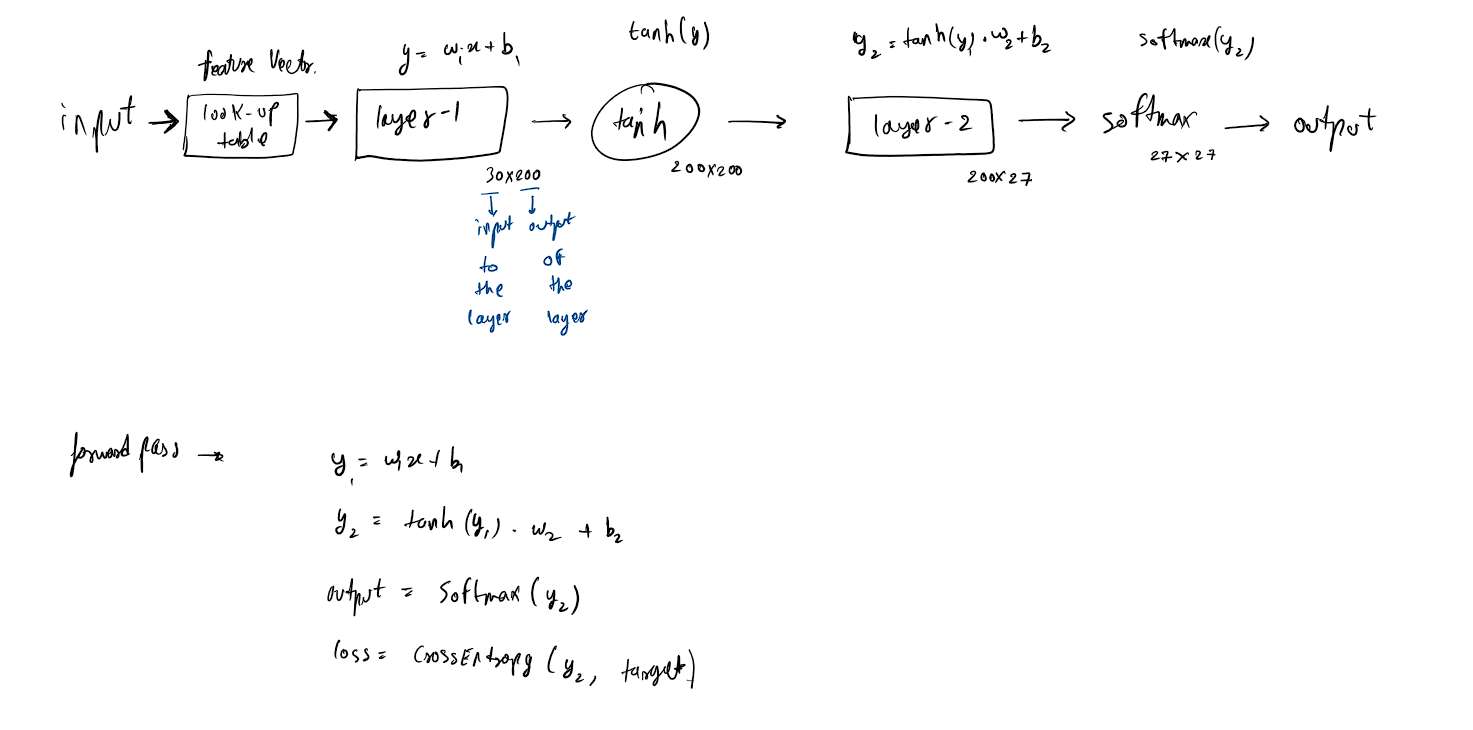

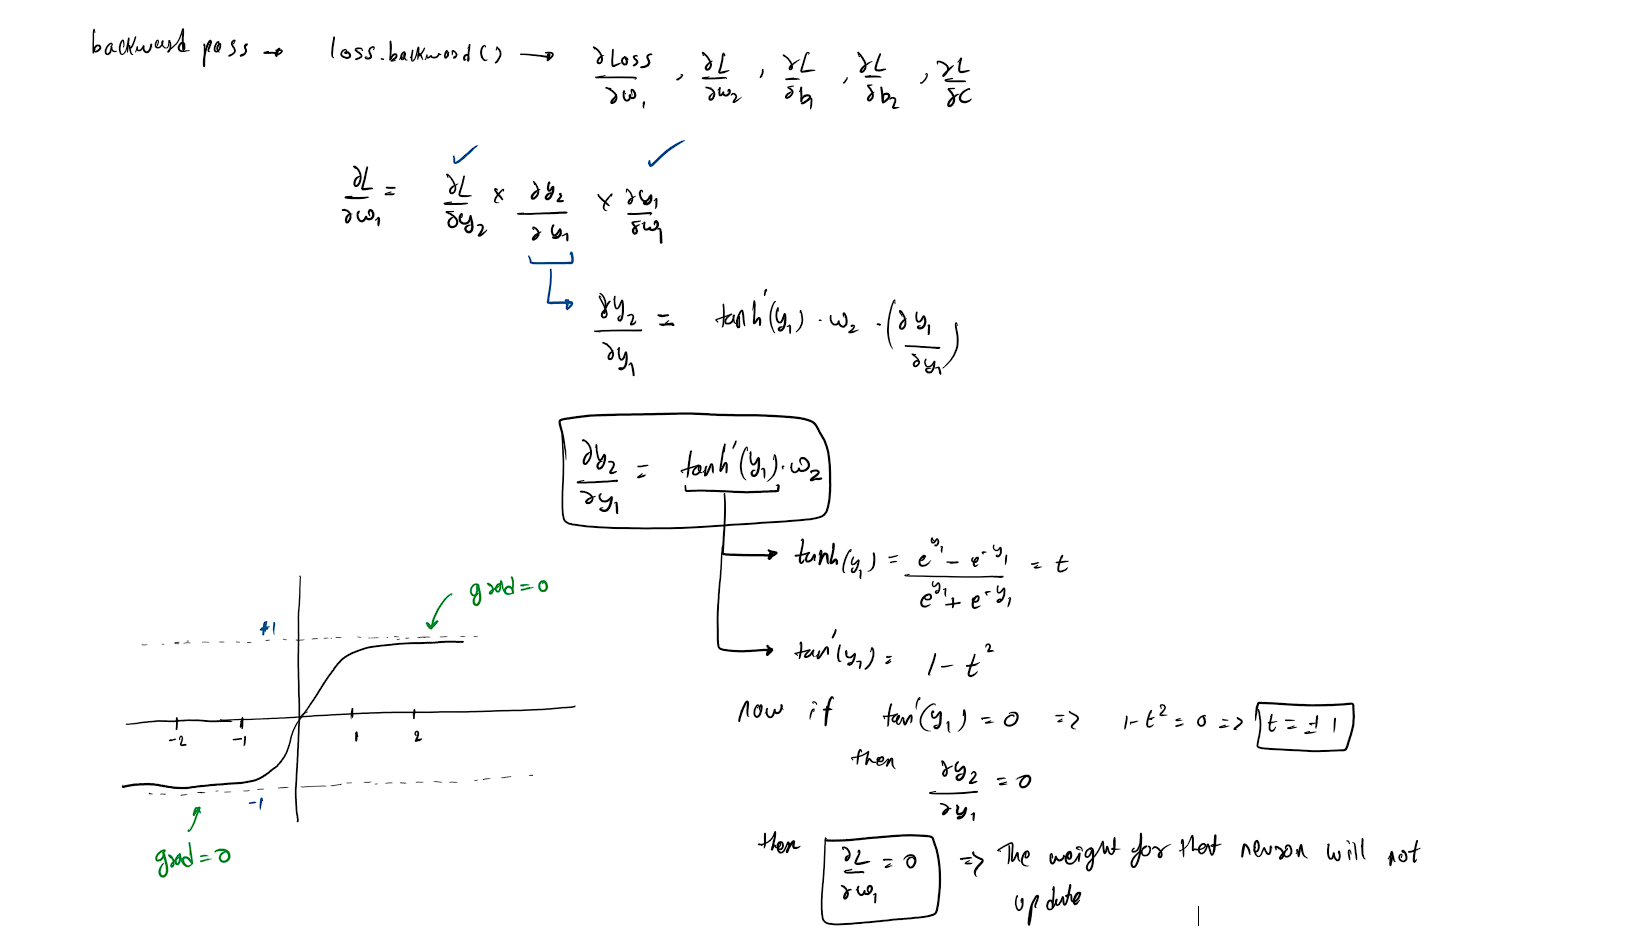

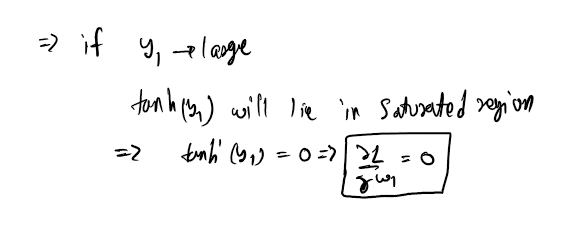

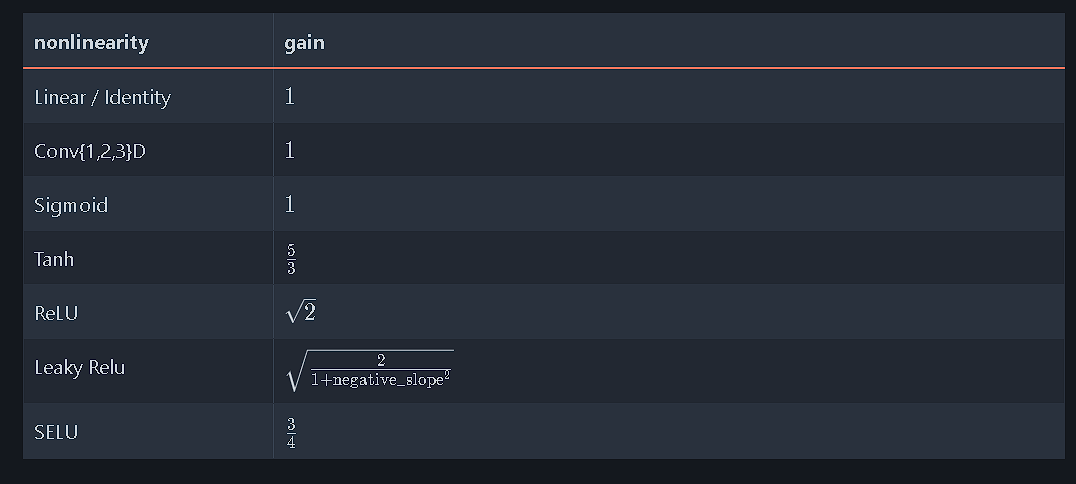

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', mode = 'r', encoding='utf-8').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i:c for c, i in stoi.items()}

In [4]:
x, y = [], []
block_size = 3
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        idx = stoi[ch]
        x.append(context)
        y.append(idx)
        # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
        context = context[1:] + [idx]
x, y = torch.tensor(x), torch.tensor(y)

In [5]:
def generate_dataset(words):
    x, y = [], []
    block_size = 3
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            x.append(context)
            y.append(idx)
            # print(f"{''.join([itos[i] for i in context])} --> {itos[idx]}")
            context = context[1:] + [idx]
    x, y = torch.tensor(x), torch.tensor(y)
    return x, y

def get_split(data, train_split: float, test_split: float, val_split: float):
    import random
    random.seed(42)

    if (train_split + test_split + val_split) != 1:
        raise ValueError("All splits must sum to 100% of the data")
    else: 
        random.shuffle(data)
        n1 = int(train_split* len(data))
        n2 = int((train_split + val_split) * len(data))
        x_train, y_train = generate_dataset(data[:n1])
        x_val, y_val = generate_dataset(data[n1:n2])
        x_test, y_test = generate_dataset(data[n2:])

        return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_split(data = words, train_split = 0.8, test_split = 0.1, val_split = 0.1)

## Implementing the Look-up Table
- According to the Research Paper, they implemented a look-up table to map their 27K input vector space into a 30-dimensional vector space.  
- In my case, I will create a look-up table that transforms my 27-dimensional vector space into a 2-dimensional vector space.

### Fixing issues

In [6]:
g = torch.Generator().manual_seed(42)
C = torch.nn.Parameter(torch.randn((27, 10), generator = g) * 0.01) # Look-up table
out_features = 200  
n_classes = 27
emb = C[x_train]
lr = 0.1

# Calculate gain wrt Tanh activation function
gain = torch.nn.init.calculate_gain(nonlinearity="tanh")

# Layer-1
# weight_1 = torch.randn(((emb.shape[1] * emb.shape[2]), out_features), generator = g, requires_grad = True)
weight_1 = torch.nn.Parameter((gain) / ((emb.shape[1] * emb.shape[2]) ** 0.5) * torch.randn((emb.shape[1] * emb.shape[2]), out_features)) # This will ensure that the input to the tanh will not lie in saturated region
# bias_1 = torch.randn(out_features, generator = g, requires_grad = True)
bias_1 = torch.nn.Parameter(0.01 * torch.randn(out_features)) # This will ensure that the input to the tanh will not lie in saturated region

# Layer-2
weight_2 = torch.nn.Parameter(0.01 * torch.randn((out_features, n_classes))) # Reduced the weight_2
bias_2 = torch.zeros(n_classes, requires_grad = True) # set bias_2 to zero to ensure that the logits will come close to 0

# Hidden Layer
hidden_layer_1_output = None

# Parameters counting
parameters = [C, weight_1, weight_2, bias_1, bias_2]
for p in parameters:
    p.requires_grad = True
n_parameters = sum(p.nelement() for p in parameters)
print(f"Total Trainable Parameters with current settings = {n_parameters}")

Total Trainable Parameters with current settings = 11897


In [7]:
epochs = []
loss_i = []
max_steps = 200000
for i in range(max_steps):
    # Mini-batch generation
    rand_idx = torch.randint(0, x_train.shape[0], (32,))

    # Forward pass
    # Layer-1:
    emb = C[x_train[rand_idx]]
    layer_1_output = (emb.view(-1, 30) @ weight_1) + bias_1
    hidden_layer_1_output = torch.tanh(layer_1_output)

    # Layer-2:
    layer_2_output = (hidden_layer_1_output @ weight_2) + bias_2
    logits = layer_2_output

    # Evaluating Loss
    loss = F.cross_entropy(logits, y_train[rand_idx])

    # if i % 500 == 0:
    #     print(f"Epoch-{i+100} Loss: {loss:.3f}")

    # Backward pass
    for p in parameters:
        p.grad = None

    # Updating the Model's 
    lr = 0.1 if i < 100000 else 0.01
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 10500 == 0:
        print(f"{i} / {max_steps}: Loss = {loss:.3f}")
    epochs.append(i)
    loss_i.append(loss.item())

    # break

0 / 200000: Loss = 3.297
10500 / 200000: Loss = 2.140
21000 / 200000: Loss = 2.342
31500 / 200000: Loss = 2.646
42000 / 200000: Loss = 1.996
52500 / 200000: Loss = 2.351
63000 / 200000: Loss = 2.499
73500 / 200000: Loss = 2.186
84000 / 200000: Loss = 2.227
94500 / 200000: Loss = 2.100
105000 / 200000: Loss = 2.316
115500 / 200000: Loss = 1.751
126000 / 200000: Loss = 2.272
136500 / 200000: Loss = 1.692
147000 / 200000: Loss = 2.235
157500 / 200000: Loss = 2.267
168000 / 200000: Loss = 2.189
178500 / 200000: Loss = 1.966
189000 / 200000: Loss = 2.224
199500 / 200000: Loss = 1.841


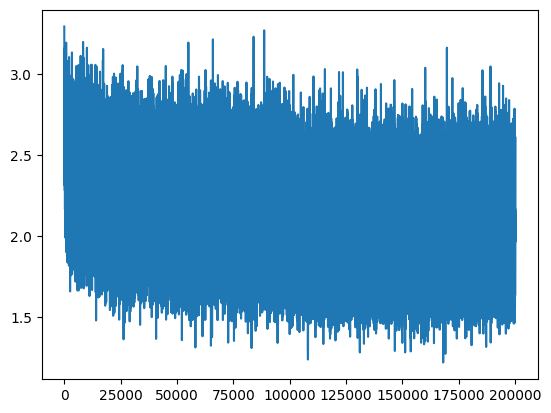

In [8]:
plt.plot(epochs, loss_i)

In [9]:
# Evaluate the loss on validation test
def eval_loss(split):
    if split == "train":
        x_data, y_data = x_train, y_train
    elif split == "test":
        x_data, y_data = x_test, y_test
    elif split == "val":
        x_data, y_data = x_val, y_val
    else:
        raise ValueError("split must be 'train', 'test', or 'val'")

    emb = C[x_data]
    hidden_layer_output = torch.tanh((emb.view(-1, 30) @ weight_1) + bias_1)
    logits = (hidden_layer_output @ weight_2) + bias_2
    loss_val = F.cross_entropy(logits, y_data)
    print(f"Loss on {split} split = {loss_val}")
    return loss_val

val_loss = eval_loss('val')
test_loss = eval_loss('test')
train_loss = eval_loss('train')

Loss on val split = 2.1101691722869873
Loss on test split = 2.10625958442688
Loss on train split = 2.047945976257324


## Predictions of our Model

In [12]:
g = torch.Generator().manual_seed(42)

for _ in range(40):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        hidden_layer_output = torch.tanh(emb.view(1, -1) @ weight_1 + bias_1)
        logits = hidden_layer_output @ weight_2 + bias_2
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

yessy.
haviah.
nolle.
khalei.
nya.
trysteritel.
emberlynn.
ize.
abdihaanis.
atouralitai.
pupo.
khadzi.
lorenilah.
whina.
lundyanahi.
zeriagreen.
kelsemale.
eiliony.
rinochrishan.
ana.
bani.
anna.
skalo.
hudwummini.
zei.
anaelee.
oxten.
gylina.
auniden.
mykarae.
karreeclio.
aina.
stashengelea.
rick.
madelah.
shasliam.
lynna.
kaliah.
rozi.
alynn.


### **Conclusion**

The experimental results demonstrate a progressive improvement in model performance following successive refinements:

* **Initial training phase:**

  $$
  \text{Validation Loss} = 2.1631, \quad \text{Test Loss} = 2.1624, \quad \text{Training Loss} = 2.1231
  $$

* **After correcting the softmax implementation:**

  $$
  \text{Validation Loss} = 2.1264, \quad \text{Test Loss} = 2.1288, \quad \text{Training Loss} = 2.0644
  $$

* **After addressing saturation in the $\tanh(x)$ activation (vanishing gradient issue):**

  $$
  \text{Validation Loss} = 2.1032, \quad \text{Test Loss} = 2.1062, \quad \text{Training Loss} = 2.0479
  $$

These results highlight that both the correction of the **softmax output layer** and the mitigation of the **vanishing gradient problem in `tanh`** contributed to stabilizing training and reducing loss values across validation, test, and training splits.

However, in modern architectures, such issues are more systematically resolved using **Batch Normalization** (Ioffe & Szegedy, 2015), **Layer Normalization** (Ba et al., 2016), and related normalization techniques. The central idea is to maintain the **standard deviation of inputs and outputs of activation layers** close to 1. Instead of manually computing the relationship between the variance of inputs and outputs across layers, normalization methods directly standardize either the entire batch (BatchNorm) or the entire layer (LayerNorm). This ensures stable signal propagation and alleviates vanishing/exploding gradients.

I will further explore and implement these normalization techniques in **`3_MLP_v3.ipynb`**, where their effectiveness will be demonstrated in practice.

---

### **References**

1. Glorot, X., & Bengio, Y. (2010). *Understanding the difficulty of training deep feedforward neural networks*. Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics (AISTATS), 249–256.
2. He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*. Proceedings of the IEEE International Conference on Computer Vision (ICCV), 1026–1034.
3. Ioffe, S., & Szegedy, C. (2015). *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*. Proceedings of the 32nd International Conference on Machine Learning (ICML), 448–456.
4. Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). *Layer Normalization*. arXiv preprint arXiv:1607.06450.